In [113]:
import env
import pandas as pd
import requests as req
import acquire
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

# Acquisition Exercises

1. Using the code from the lesson as a guide and the REST API from https://python.zach.lol/api/v1/items as we did in the lesson, create a dataframe named items that has all of the data for items.

In [13]:
endpoint = "https://python.zach.lol/api/v1/items"

In [14]:
response = req.get(endpoint)

In [15]:
response = response.json()

In [16]:
payload = response['payload']
payload

{'items': [{'item_brand': 'Riceland',
   'item_id': 1,
   'item_name': 'Riceland American Jazmine Rice',
   'item_price': 0.84,
   'item_upc12': '35200264013',
   'item_upc14': '35200264013'},
  {'item_brand': 'Caress',
   'item_id': 2,
   'item_name': 'Caress Velvet Bliss Ultra Silkening Beauty Bar - 6 Ct',
   'item_price': 6.44,
   'item_upc12': '11111065925',
   'item_upc14': '11111065925'},
  {'item_brand': 'Earths Best',
   'item_id': 3,
   'item_name': 'Earths Best Organic Fruit Yogurt Smoothie Mixed Berry',
   'item_price': 2.43,
   'item_upc12': '23923330139',
   'item_upc14': '23923330139'},
  {'item_brand': 'Boars Head',
   'item_id': 4,
   'item_name': 'Boars Head Sliced White American Cheese - 120 Ct',
   'item_price': 3.14,
   'item_upc12': '208528800007',
   'item_upc14': '208528800007'},
  {'item_brand': 'Back To Nature',
   'item_id': 5,
   'item_name': 'Back To Nature Gluten Free White Cheddar Rice Thin Crackers',
   'item_price': 2.61,
   'item_upc12': '759283100036',

In [17]:
n = payload['max_page']

In [18]:
item_list = []
url = "https://python.zach.lol/api/v1/items"

for i in range(1, n+1):
    new_url = url + "?page=" + str(i)
    response = req.get(new_url)
    data = response.json()
    page_items = data['payload']['items']
    item_list += page_items
    
item_list

[{'item_brand': 'Riceland',
  'item_id': 1,
  'item_name': 'Riceland American Jazmine Rice',
  'item_price': 0.84,
  'item_upc12': '35200264013',
  'item_upc14': '35200264013'},
 {'item_brand': 'Caress',
  'item_id': 2,
  'item_name': 'Caress Velvet Bliss Ultra Silkening Beauty Bar - 6 Ct',
  'item_price': 6.44,
  'item_upc12': '11111065925',
  'item_upc14': '11111065925'},
 {'item_brand': 'Earths Best',
  'item_id': 3,
  'item_name': 'Earths Best Organic Fruit Yogurt Smoothie Mixed Berry',
  'item_price': 2.43,
  'item_upc12': '23923330139',
  'item_upc14': '23923330139'},
 {'item_brand': 'Boars Head',
  'item_id': 4,
  'item_name': 'Boars Head Sliced White American Cheese - 120 Ct',
  'item_price': 3.14,
  'item_upc12': '208528800007',
  'item_upc14': '208528800007'},
 {'item_brand': 'Back To Nature',
  'item_id': 5,
  'item_name': 'Back To Nature Gluten Free White Cheddar Rice Thin Crackers',
  'item_price': 2.61,
  'item_upc12': '759283100036',
  'item_upc14': '759283100036'},
 {'i

In [19]:
items_df = pd.DataFrame(item_list)

In [20]:
items_df

,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
0,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
1,Caress,2,Caress Velvet Bliss Ultra Silkening Beauty Bar...,6.44,11111065925,11111065925
2,Earths Best,3,Earths Best Organic Fruit Yogurt Smoothie Mixe...,2.43,23923330139,23923330139
3,Boars Head,4,Boars Head Sliced White American Cheese - 120 Ct,3.14,208528800007,208528800007
4,Back To Nature,5,Back To Nature Gluten Free White Cheddar Rice ...,2.61,759283100036,759283100036
5,Sally Hansen,6,Sally Hansen Nail Color Magnetic 903 Silver El...,6.93,74170388732,74170388732
6,Twinings Of London,7,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004
7,Lea & Perrins,8,Lea & Perrins Marinade In-a-bag Cracked Pepper...,1.68,51600080015,51600080015
8,Van De Kamps,9,Van De Kamps Fillets Beer Battered - 10 Ct,1.79,19600923015,19600923015
9,Ahold,10,Ahold Cocoa Almonds,3.17,688267141676,688267141676


In [23]:
def create_df_from_payloads(endpoint, max_pages, target_key_name):
    page_list = []
    
    for i in range(1, max_pages + 1):
        response = req.get(endpoint + "?page=" + str(i))
        data = response.json()
        page_items = data['payload'][target_key_name]
        page_list += page_items
        
    return pd.DataFrame(page_list)

In [24]:
test_df = create_df_from_payloads("https://python.zach.lol/api/v1/items", 3, 'items')
test_df.shape

(50, 6)

2. Do the same thing, but for stores (https://python.zach.lol/api/v1/stores)

In [25]:
response = req.get("https://python.zach.lol/api/v1/stores")
response = response.json()

In [26]:
stores_df = create_df_from_payloads("https://python.zach.lol/api/v1/stores", 1, 'stores')

In [27]:
stores_df

,store_address,store_city,store_id,store_state,store_zipcode
0,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
1,9255 FM 471 West,San Antonio,2,TX,78251
2,2118 Fredericksburg Rdj,San Antonio,3,TX,78201
3,516 S Flores St,San Antonio,4,TX,78204
4,1520 Austin Hwy,San Antonio,5,TX,78218
5,1015 S WW White Rd,San Antonio,6,TX,78220
6,12018 Perrin Beitel Rd,San Antonio,7,TX,78217
7,15000 San Pedro Ave,San Antonio,8,TX,78232
8,735 SW Military Dr,San Antonio,9,TX,78221
9,8503 NW Military Hwy,San Antonio,10,TX,78231


3. Extract the data for sales (https://python.zach.lol/api/v1/sales). There are a lot of pages of data here, so your code will need to be a little more complex. Your code should continue fetching data from the next page until all of the data is extracted.

In [30]:
response columnsget("https://python.zach.lol/api/v1/sales")
response = response.json()

max_pages = response['payload']['max_page']

In [32]:
sales_df = create_df_from_payloads("https://python.zach.lol/api/v1/sales", max_pages, 'sales')
sales_df

,item,sale_amount,sale_date,sale_id,store
0,1,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,1
1,1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,1
2,1,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,1
3,1,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,1
4,1,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,1
...,...,...,...,...,...
912995,50,63.0,"Wed, 27 Dec 2017 00:00:00 GMT",912996,10
912996,50,59.0,"Thu, 28 Dec 2017 00:00:00 GMT",912997,10
912997,50,74.0,"Fri, 29 Dec 2017 00:00:00 GMT",912998,10
912998,50,62.0,"Sat, 30 Dec 2017 00:00:00 GMT",912999,10


4. Save the data in your files to local csv files so that it will be faster to access in the future.

In [34]:
sales_df.to_csv("sales.csv", index=False)
stores_df.to_csv("stores.csv", index=False)
items_df.to_csv("items.csv", index=False)

5. Combine the data from your three separate dataframes into one large dataframe.

In [36]:
items_df.columns

Index(['item_brand', 'item_id', 'item_name', 'item_price', 'item_upc12',
       'item_upc14'],
      dtype='object')

In [37]:
stores_df.columns

Index(['store_address', 'store_city', 'store_id', 'store_state',
       'store_zipcode'],
      dtype='object')

In [38]:
sales_df.columns

Index(['item', 'sale_amount', 'sale_date', 'sale_id', 'store'], dtype='object')

In [40]:
sales_df.rename(columns={'item' : 'item_id'}, inplace=True)
merged_df = pd.merge(items_df, sales_df, how="left", on="item_id")

merged_df.rename(columns={'store' : 'store_id'}, inplace=True)
merged_df = pd.merge(merged_df, stores_df, how="left", on="store_id")

merged_df.columns

6. Acquire the Open Power Systems Data for Germany, which has been rapidly expanding its renewable energy production in recent years. The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017. You can get the data here: https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv

In [11]:
response = req.get("https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv")

csv = StringIO(response.text)

germany_df = pd.read_csv(csv)

In [12]:
germany_df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [8]:
items_df = acquire.acquire_df_from_zach_api("https://python.zach.lol/api/v1/items", 'items')
items_df.shape

(50, 6)

In [9]:
stores_df = acquire.acquire_df_from_zach_api("https://python.zach.lol/api/v1/stores", 'stores')
stores_df.shape

(10, 5)

In [10]:
sales_df = pd.read_csv("sales.csv")
sales_df.shape

(913000, 5)

In [5]:
final_df = acquire.merge_zach_dataframes(items_df, stores_df, sales_df)
final_df.shape

(913000, 14)

In [7]:
germany_df = acquire.acquire_germany()
germany_df.shape

(4383, 5)

# Working with time series data exercises

* Use the above dataset for the exercises below:

In [115]:
from vega_datasets import data
data.sf_temps()

,temp,date
0,47.8,2010-01-01 00:00:00
1,47.4,2010-01-01 01:00:00
2,46.9,2010-01-01 02:00:00
3,46.5,2010-01-01 03:00:00
4,46.0,2010-01-01 04:00:00
...,...,...
8754,50.4,2010-12-31 19:00:00
8755,49.9,2010-12-31 20:00:00
8756,49.4,2010-12-31 21:00:00
8757,48.8,2010-12-31 22:00:00


1. Resample by the day and take the average temperature. Visualize the average temperature over time.

In [123]:
temps_df = data.sf_temps()
temps_df['date'] = pd.to_datetime(temps_df['date'])
temps_df.dtypes

temp           float64
date    datetime64[ns]
dtype: object

In [130]:
temps_df = temps_df.set_index('date').sort_index()

In [131]:
daily_mean_temps_df = temps_df.resample('D').mean()

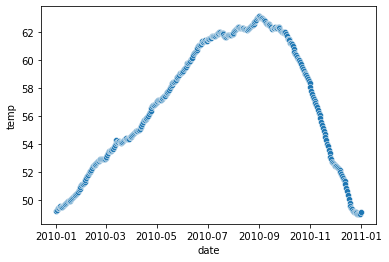

In [132]:
sns.scatterplot(x=daily_mean_temps_df.index, y=daily_mean_temps_df.temp)
plt.show()

2. Write the code necessary to visualize the minimum temperature over time.

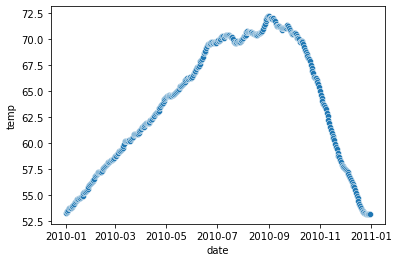

In [133]:
daily_max_temps = temps_df.resample('D').max()

sns.scatterplot(x=daily_max_temps.index, y=daily_max_temps.temp)
plt.show()

3. Write the code necessary to visualize the maximum tempberature over time.

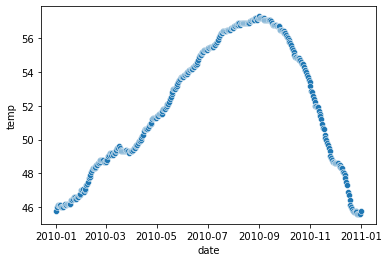

In [134]:
daily_min_temps = temps_df.resample('D').min()

sns.scatterplot(x=daily_min_temps.index, y=daily_min_temps.temp)
plt.show()

4. Which month is the coldest, on average?

In [142]:
monthly_temps = temps_df.resample('M').mean()
monthly_temps.nsmallest(1, 'temp')

,temp
date,
2010-01-31,49.98414


5. Which month has the highest average temperature?

In [143]:
monthly_temps.nlargest(1, 'temp')

,temp
date,
2010-09-30,62.487083


6. Resample by the day and calculate the min and max temp for the day (Hint: .agg(['min', 'max'])). Use this resampled dataframe to calculate the change in temperature for the day. Which month has the highest daily temperature variability?

In [146]:
daily_temps = temps_df.resample('D').agg(['min', 'max'])

In [160]:
daily_temps = daily_temps.droplevel(0, axis=1)

In [161]:
daily_temps['temp_change'] = daily_temps['max'] - daily_temps['min']

In [165]:
daily_temps.nlargest(1, 'temp_change')

,min,max,temp_change
date,,,
2010-08-31,57.2,72.2,15.0


In [169]:
monthly_variability = daily_temps.temp_change.resample('M').max()
monthly_variability.nlargest(1)

date
2010-08-31    15.0
Freq: M, Name: temp_change, dtype: float64

7. Bonus: Visualize the daily min, average, and max temperature over time on a single line plot, i.e. the min, average, and maximum temperature should be 3 seperate lines.

In [171]:
daily_temps = temps_df.resample('D').agg(['min', 'mean', 'max'])
daily_temps

temp                 
             min       mean   max
date                             
2010-01-01  45.8  49.170833  53.3
2010-01-02  46.0  49.304167  53.4
2010-01-03  46.1  49.391667  53.5
2010-01-04  46.1  49.445833  53.6
2010-01-05  46.1  49.491667  53.8
...          ...        ...   ...
2010-12-27  45.6  48.991667  53.2
2010-12-28  45.6  49.000000  53.2
2010-12-29  45.6  49.012500  53.2
2010-12-30  45.6  49.012500  53.2
2010-12-31  45.8  49.116667  53.2

[365 rows x 3 columns]

In [172]:
daily_temps = daily_temps.droplevel(0, axis=1)

In [173]:
daily_temps.sample(14)

,min,mean,max
date,,,
2010-08-09,56.8,62.308333,70.7
2010-05-02,51.4,57.091667,64.5
2010-03-30,49.3,54.458333,61.2
2010-07-05,55.5,61.583333,70.0
2010-10-18,54.8,60.033333,68.2
2010-11-10,51.9,56.441667,62.6
2010-07-02,55.4,61.525000,69.9
2010-04-20,50.6,55.920833,63.0
2010-02-08,47.5,51.804167,57.1


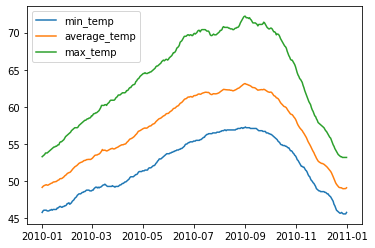

In [184]:
plt.plot(daily_temps.index, daily_temps['min'], label="min_temp")
plt.plot(daily_temps.index, daily_temps['mean'], label="average_temp")
plt.plot(daily_temps.index, daily_temps['max'], label="max_temp")
plt.legend()
plt.show()